In [1]:
import pandas as pd

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import torch
import numpy as np
import pickle as pk

from tqdm import tqdm_notebook
from sklearn.metrics import cohen_kappa_score
from fastai.vision import *
from torch.nn import functional as F
from utils import *

In [2]:
current_time = get_BJ_time()
print(current_time)

0906_06-09-42


In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

deployment_dir = "../output/inference"

def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

df_2019_cv = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')

In [4]:
df_2019_cv.head()

,id_code,diagnosis,path,is_valid1,is_valid2,is_valid3,is_valid4,is_valid5
0,000c1434d8d7,2,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
1,001639a390f0,4,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
2,0024cdab0c1e,1,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
3,002c21358ce6,0,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False
4,005b95c28852,0,../input/aptos2019-blindness-detection/train_i...,True,False,False,False,False


In [5]:
test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# Feature Extraction

## Train logits

### b3

In [6]:
b3_models = ["efficientnet-b3_0901_16-45-51_stage2_f1", "efficientnet-b3_0901_16-45-51_stage2_f2",
                  "efficientnet-b3_0901_16-45-51_stage2_f3", "efficientnet-b3_0901_16-45-51_stage2_f4",
                  "efficientnet-b3_0901_16-45-51_stage2_f5"]

b3_train_logits_list = []

for i, m in enumerate(b3_models):
    fold = i + 1
    learn = load_learner(deployment_dir, "{}.pkl".format(m))
    val_df = df_2019_cv[df_2019_cv["is_valid{}".format(fold)]]
    learn.data.add_test(ImageList.from_df(val_df,
                                          '../input/aptos2019-blindness-detection',
                                          cols="id_code",
                                          folder='train_images_ben_preprocessing_sigmaX10',
                                          suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_train_logits_list.append(logits)
    np.save("../output/stacking/{}_logits.npy".format(m), logits)

    print(logits.shape)

### b4

In [7]:
b4_models = ["efficientnet-b4_0820_01-09-57_stage2_f1", "efficientnet-b4_0820_01-09-57_stage2_f2",
                  "efficientnet-b4_0820_01-09-57_stage2_f3", "efficientnet-b4_0820_01-09-57_stage2_f4",
                  "efficientnet-b4_0821_00-02-25_stage2_f5"]

b4_train_logits_list = []
for i, m in enumerate(b4_models):
    fold = i + 1
    learn = load_learner(deployment_dir, "{}.pkl".format(m))
    val_df = df_2019_cv[df_2019_cv["is_valid{}".format(fold)]]
    learn.data.add_test(ImageList.from_df(val_df,
                                          '../input/aptos2019-blindness-detection',
                                          cols="id_code",
                                          folder='train_images_ben_preprocessing_sigmaX10',
                                          suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_train_logits_list.append(logits)
    np.save("../output/stacking/{}_logits.npy".format(m), logits)

    print(logits.shape)

### b5

In [8]:
b5_models = ["efficientnet-b5_0820_01-32-30_stage2_f1", "efficientnet-b5_0903_01-03-41_stage2_f2",
                  "efficientnet-b5_0820_22-13-07_stage2_f3", "efficientnet-b5_0821_01-30-37_stage2_f4",
                  "efficientnet-b5_0821_00-26-51_stage2_f5"]

b5_train_logits_list = []
for i, m in enumerate(b5_models):
    fold = i + 1
    learn = load_learner(deployment_dir, "{}.pkl".format(m))
    val_df = df_2019_cv[df_2019_cv["is_valid{}".format(fold)]]
    learn.data.add_test(ImageList.from_df(val_df,
                                          '../input/aptos2019-blindness-detection',
                                          cols="id_code",
                                          folder='train_images_ben_preprocessing_sigmaX10',
                                          suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_train_logits_list.append(logits)
    np.save("../output/stacking/{}_logits.npy".format(m), logits)

    print(logits.shape)

## Test Feature

### Average

#### b3

In [9]:
b3_test_logits_list = []
for m in b3_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b3_test_logits_list.append(logits)
    
    np.save("../output/stacking/{}_logits_test.npy".format(m), logits)
    print(logits.shape)

(1928, 1)


#### b4

In [10]:
b4_test_logits_list = []
for m in b4_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b4_test_logits_list.append(logits)
    
    np.save("../output/stacking/{}_logits_test.npy".format(m), logits)
    print(logits.shape)

(1928, 1)


#### b5

In [11]:
b5_test_logits_list = []
for m in b5_models:
    learn = load_learner(deployment_dir, "{}.pkl".format(m))

    learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
    logits,_ = learn.get_preds(DatasetType.Test)
    logits = logits.numpy()
    b5_test_logits_list.append(logits)
    
    np.save("../output/stacking/{}_logits_test.npy".format(m), logits)
    print(logits.shape)

(1928, 1)


# Train Stage 2 model on OOF

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [20]:
def qk_np(y, y_pred):
    k = cohen_kappa_score(np.round(y_pred), y, weights='quadratic')
    
    return k

score = make_scorer(qk_np, greater_is_better=True)

In [12]:
b3_train_logits_list = []
for m in b3_models:
    logits = np.load("../output/stacking/{}_logits.npy".format(m))
    b3_train_logits_list.append(logits)

    print(logits.shape)
    
b4_train_logits_list = []
for m in b4_models:
    logits = np.load("../output/stacking/{}_logits.npy".format(m))
    b4_train_logits_list.append(logits)

    print(logits.shape)

b5_train_logits_list = []
for m in b5_models:
    logits = np.load("../output/stacking/{}_logits.npy".format(m))
    b5_train_logits_list.append(logits)

    print(logits.shape)
    

(733, 1)
(733, 1)
(733, 1)
(732, 1)
(731, 1)
(733, 1)
(733, 1)
(733, 1)
(732, 1)
(731, 1)
(733, 1)
(733, 1)
(733, 1)
(732, 1)
(731, 1)


In [13]:
X_train = np.concatenate([np.concatenate(b3_train_logits_list, axis=0),
                         np.concatenate(b4_train_logits_list, axis=0),
                         np.concatenate(b5_train_logits_list, axis=0)], axis=1)
y_train = []
n_fold = 5

for i in range(1, n_fold+1):
    label_t = df_2019_cv[df_2019_cv["is_valid{}".format(i)]]["diagnosis"].tolist()
    y_train += label_t
    
print(X_train.shape)

(3662, 3)


## LightGBM 

In [46]:
import lightgbm as lgb

In [ ]:
estimator = lgb.LGBMRegressor(random_state=SEED)

param_grid = {
    'max_depth': [3, 5],     
#     'max_depth': [5],   
#     'learning_rate': [0.05], 
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
#     'feature_fraction': [0.7],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
#     'bagging_fraction': [0.7],
#     'bagging_freq': [8],
    'bagging_freq': [5, 6, 8],
    'lambda_l1': [0, 0.1, 0.4],
#     'lambda_l1': [0],
#     'lambda_l2': [15],
    'lambda_l2': [0, 10, 15, 20],
#     'cat_smooth': [1],
    'cat_smooth': [1, 10, 15],
}

gbm = GridSearchCV(estimator, param_grid, cv=5, n_jobs=-1, scoring=score, verbose=1)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Fitting 5 folds for each of 16200 candidates, totalling 81000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1122 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 1672 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 2322 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 3072 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 4872 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 5922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7072 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8322 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 9672 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 11122 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 12672 tasks    

In [ ]:
gbm.cv_results_   

In [ ]:
print(gbm.best_score_, qk_np(y_train, xlf.predict(X_train)))

In [ ]:
model_save_name = "lightgbm-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
    pk.dump(gbm.best_estimator_, f)

print(model_save_name)

## XGBoost 

In [33]:
import xgboost as xgb

In [44]:
estimator_xgb = xgb.XGBRegressor(n_jobs=8, random_state=SEED)

parameters = {
              'max_depth': [3],
              'learning_rate': [0.1],
#               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'min_child_weight': [20],
#               'min_child_weight': [0, 2, 5, 10, 20],
              'max_delta_step': [2],
#               'max_delta_step': [0, 0.2, 0.6, 1, 2],
              'subsample': [0.8],
#               'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
              'colsample_bytree': [0.7],
#               'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_alpha': [0],
#               'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
              'reg_lambda': [0.6],
#               'reg_lambda': [0.2, 0.4, 0.6, 0.8, 1],
              'scale_pos_weight': [0.8]
#               'scale_pos_weight': [0.2, 0.4, 0.6, 0.8, 1]
}

xlf = GridSearchCV(estimator_xgb, parameters, cv=5, n_jobs=16, scoring=score, verbose=1)
xlf.fit(X_train, y_train)

print('Best parameters found by grid search are:', xlf.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   27.9s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  4.0min


Best parameters found by grid search are: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 3, 'min_child_weight': 20, 'reg_alpha': 0, 'reg_lambda': 0.6, 'scale_pos_weight': 0.8, 'subsample': 0.8}


[Parallel(n_jobs=16)]: Done 625 out of 625 | elapsed:  5.8min finished


In [45]:
xlf.cv_results_ 

{'mean_fit_time': array([16.576894, 19.437918, 24.421603,  7.953644, ...,  3.725325,  2.692475,  1.895665,  1.726808]),
 'std_fit_time': array([5.719804, 7.203137, 5.606267, 4.825887, ..., 0.258053, 0.426859, 0.324031, 0.263813]),
 'mean_score_time': array([0.389374, 0.853573, 0.906028, 0.447795, ..., 0.974211, 1.474732, 1.209976, 1.393587]),
 'std_score_time': array([0.327546, 0.909945, 0.826804, 0.317137, ..., 0.33777 , 0.426922, 0.727559, 0.281498]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.7, ..., 0.7, 0.7, 0.7, 0.7],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_delta_step': masked_array(data=[2, 2, 2, 2, ..., 2, 2, 2, 2],
              mask=

In [46]:
print(xlf.best_score_, qk_np(y_train, xlf.predict(X_train)))

0.9275440917207455 0.9360609597886036


In [47]:
model_save_name = "xgboost-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
    pk.dump(xlf.best_estimator_, f)

print(model_save_name)

xgboost-0903_05-26-03


## SVR 

In [9]:
from sklearn.svm import SVR

In [ ]:
# svr = SVR(gamma=0.0001, C=100)
estimator_svr = SVR()


tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svr = GridSearchCV(estimator_svr, tuned_parameters, cv=5, n_jobs=16, scoring=score, verbose=1)
svr.fit(X_train, y_train)

print('Best parameters found by grid search are:', svr.best_params_)

In [52]:
svr.cv_results_ 

{'mean_fit_time': array([ 0.449111,  0.725864,  0.449926,  0.404292,  0.408877,  0.384097,  0.534327,  0.382056,  0.464625,  1.704576,
        10.272197, 88.658682]),
 'std_fit_time': array([3.030703e-02, 2.183755e-02, 8.633045e-02, 1.061797e-01, 3.863933e-03, 4.550244e-03, 1.438193e-02, 1.364801e-02,
        3.683297e-02, 1.674361e-01, 1.229205e+00, 6.570119e+00]),
 'mean_score_time': array([0.037776, 0.053958, 0.035569, 0.032954, 0.035365, 0.034078, 0.027068, 0.026811, 0.008165, 0.009239, 0.008616,
        0.009378]),
 'std_score_time': array([0.002869, 0.007793, 0.007139, 0.003456, 0.003501, 0.006972, 0.000804, 0.000662, 0.000259, 0.001165, 0.000126,
        0.001421]),
 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0

In [53]:
print(svr.best_score_, qk_np(y_train, svr.predict(X_train)))

0.9255694040131046 0.9251493380866914


In [22]:
model_save_name = "svr-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
# with open(os.path.join(deployment_dir, "svr-0903_05-26-03.pkl"), "wb") as f:
    pk.dump(svr.best_estimator_, f)    
#     pk.dump(svr, f)

print(model_save_name)

svr-0906_06-09-42


## CatBoost

In [23]:
from catboost import CatBoostRegressor

In [ ]:
estimator_cb = CatBoostRegressor(random_seed=SEED)

params = {
          'depth':[3,1,2,6,4,5],
#           'iterations':[500],
          'iterations':[250,500,750,1000],
#           'learning_rate':[0.2], 
          'learning_rate':[0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10],
          'border_count':[100,128, 200, 254, 300]
         }

cb = GridSearchCV(estimator_cb, params, cv=5, n_jobs=16, scoring=score, verbose=1)
cb.fit(X_train, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  3.4min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  6.0min
/home/ai/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed: 11.3min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed: 17.0min
[Parallel(n_jobs=16)]: Done 2418 tasks      | elapsed: 23.5min
[Parallel(n_jobs=16)]: Done 3168 tasks      | elapsed: 31.3min
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed: 40.5min
[Parallel(n_jobs=16)]: Done 4968 tasks      | elapsed: 49.1min
[Parallel(n_j

In [39]:
print('Best parameters found by grid search are:', cb.best_params_)
cb.cv_results_ 

Best parameters found by grid search are: {'border_count': 100, 'depth': 2, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.01}


{'mean_fit_time': array([ 2.073691,  2.13434 ,  2.14068 ,  2.136364, ..., 20.142412, 20.179307, 19.689002, 19.617364]),
 'std_fit_time': array([0.03681 , 0.069325, 0.049825, 0.106818, ..., 0.458016, 0.108471, 0.229954, 0.672636]),
 'mean_score_time': array([0.017744, 0.0152  , 0.016812, 0.012601, ..., 0.023632, 0.027577, 0.020001, 0.017893]),
 'std_score_time': array([0.003141, 0.00561 , 0.002328, 0.004984, ..., 0.003495, 0.00803 , 0.010126, 0.006715]),
 'param_border_count': masked_array(data=[100, 100, 100, 100, ..., 300, 300, 300, 300],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_depth': masked_array(data=[3, 3, 3, 3, ..., 5, 5, 5, 5],
              mask=[False, False, False, False, ..., False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_iterations': masked_array(data=[250, 250, 250, 250, ..., 1000, 1000, 1000, 1000],
              mask=[False, Fals

In [40]:
print(cb.best_score_, qk_np(y_train, cb.predict(X_train)))

0.927644233342091 0.9269977028467353


In [41]:
model_save_name = "cb-{}".format(current_time)

with open(os.path.join(deployment_dir, model_save_name+".pkl"), "wb") as f:
    pk.dump(cb.best_estimator_, f)    

print(model_save_name)

cb-0906_06-09-42


# Test

In [43]:
b3_test_logits_list = []
for m in b3_models:
    logits = np.load("../output/stacking/{}_logits_test.npy".format(m))
    b3_test_logits_list.append(logits)

    print(logits.shape)
    
b4_test_logits_list = []
for m in b4_models:
    logits = np.load("../output/stacking/{}_logits_test.npy".format(m))
    b4_test_logits_list.append(logits)

    print(logits.shape)

b5_test_logits_list = []
for m in b5_models:
    logits = np.load("../output/stacking/{}_logits_test.npy".format(m))
    b5_test_logits_list.append(logits)

    print(logits.shape)
    

(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)
(1928, 1)


## LightGBM 

In [77]:
# model_save_name = "lightgbm-0903_05-26-03"

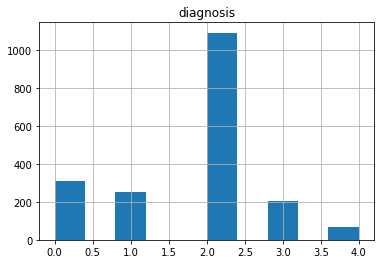

../output/submission/lightgbm-0904_04-09-19-5-fold_avg_logits_test.csv


In [98]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = gbm.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

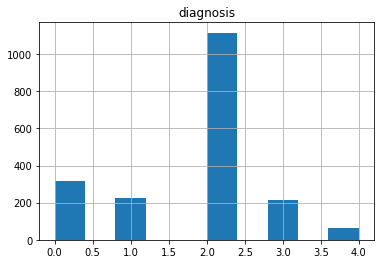

../output/submission/lightgbm-0904_04-09-19-5-fold_logits_avg_test.csv


In [100]:
# 5 test feature then avg

results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = gbm.predict(X_test)
    results.append(res)

avg_res_gbm = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_gbm)
y_pred = np.round(avg_res_gbm)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

## XGBoost 

In [101]:
model_save_name = "xgboost-0903_05-26-03"

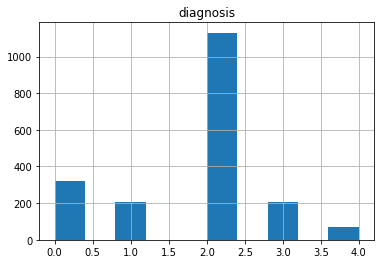

../output/submission/xgboost-0903_05-26-03-5-fold_avg_logits_test.csv


In [48]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = xlf.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

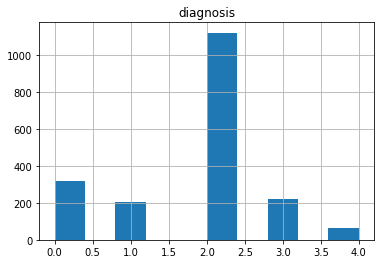

../output/submission/xgboost-0903_05-26-03-5-fold_logits_avg_test.csv


In [102]:
# 5 test feature then avg
results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = xlf.predict(X_test)
    results.append(res)

avg_res_xlf = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_xlf)
y_pred = np.round(avg_res_xlf)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

## SVR 

In [103]:
model_save_name = "svr-0903_05-26-03"

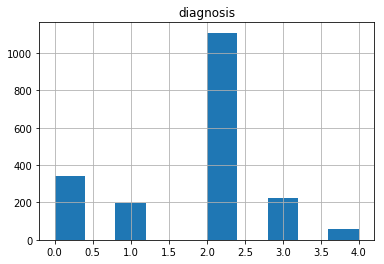

../output/submission/svr-0903_05-26-03-5-fold_avg_logits_test.csv


In [55]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = svr.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

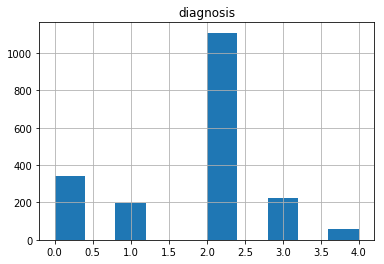

../output/submission/svr-0903_05-26-03-5-fold_logits_avg_test.csv


In [104]:
# 5 test feature then avg

results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = svr.predict(X_test)
    results.append(res)

avg_res_svr = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_svr)
y_pred = np.round(avg_res_svr)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

## CatBoost

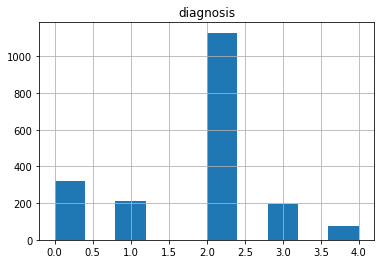

../output/submission/cb-0906_06-09-42-5-fold_avg_logits_test.csv


In [44]:
b3_test_avg_feats = np.average(b3_test_logits_list, axis=0)
b4_test_avg_feats = np.average(b4_test_logits_list, axis=0)
b5_test_avg_feats = np.average(b5_test_logits_list, axis=0)


X_test = np.concatenate([b3_test_avg_feats, b4_test_avg_feats, b5_test_avg_feats], axis=1)
y_pred = cb.predict(X_test)

y_pred = np.round(y_pred)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_avg_logits_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

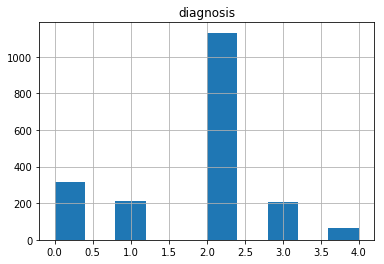

../output/submission/cb-0906_06-09-42-5-fold_logits_avg_test.csv


In [45]:
# 5 test feature then avg

results = []
for b3, b4, b5 in zip(b3_test_logits_list, b4_test_logits_list, b5_test_logits_list):
    X_test = np.concatenate([b3, b4, b5], axis=1)
    res = cb.predict(X_test)
    results.append(res)

avg_res_svr = np.average(results, axis=0)
np.save("../output/submission/{}-5-fold_logits_avg_test_logits.npy".format(model_save_name), avg_res_svr)
y_pred = np.round(avg_res_svr)

test_df.diagnosis = y_pred.astype(int)

test_df.hist()
plt.show()

submition_filename = "../output/submission/{}-5-fold_logits_avg_test.csv".format(model_save_name)
test_df.to_csv(submition_filename, index=False)
print(submition_filename)

# Correlation Analysis

In [99]:
np.corrcoef([avg_res_gbm, avg_res_xlf, avg_res_svr])

array([[1.      , 0.998509, 0.997369],
       [0.998509, 1.      , 0.997143],
       [0.997369, 0.997143, 1.      ]])